# DISCLAIMER

Due to the end of the free trial of Gcloud when i was running some parts of the notebook. I could not complete it entirely as I would have loved to. I'm sorry for that. Instead, try to run it on your own computer. I hope it will work well. It's really frustrating, after all these hours, not to be able to deliver the work I wanted to. But it seems that I have no choice. I have already gave several dozens of hours trying to make it work it out. I'm disappointed but I can't give it much more time. 
Note that I made some modifications to the test set that seems to destroy the meaning of the RMSE (since I got some 0.44 instead of 4.5). However, I think that's because I deleted the pickup lat/long values outside of NYC, this reduced greatly the test set and improved a lot performances. I think we shouldn't do it in order to keep our model as general as possible. However, our last model produce a 79% accuracy, which seemes pretty good. 

# Welcome to the DE SDD Evaluation!

Today, the goal is to understand how a distributed system can be useful when dealing with medium to large scale data sets.  
We'll see that Dask start to be nice as soon as the Data we need to process doesn't quite fit in memory, but also if we
need to launch several computations in parallel.

In this evaluation, you will:
- Use Dask to read and understand the several gigabytes input dataset in a interactive way,
- Preprocess the data in a distributed way: cleaning it up and adding some useful features,
- Launch some model training that can be parallelized on a big dataset,
- Reduce the dataset and train more accurate models on less Data,
- Do an hyper parameter search to find the best model on a small sample of Data.

In order to run and fill this notebook, you'll need to first deploy a Dask enabled Kubernetes cluster as seen before. So please use the Kubernetes_DaskHub notebook for the steps to do it.

Once the Jupyterhub is up, you can clone the DE repository from a Jupyterlab terminal to get this notebook, and select the default kernel.
```
git clone https://github.com/SupaeroDataScience/DE.git
cd DE/notebooks
```

## The Dataset

It is some statistics about NY Taxi cabs. 

See https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview, or https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data.
        
The goal of this evaluation will be to generate a model using machine learning algorithms that will predict the fare amount
of a taxi ride given the other input parameters we have.

The model will be evaluated using the Root mean squared error algorithm:  
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation.

## Try to analyze the Data using Kaggles' start-up code

As an introduction, we'll use Kaggle starters' code to get some insights on the data set and
computations we'll do and measure pandas library (non parallelized access and process) performance.

See https://www.kaggle.com/dster/nyc-taxi-fare-starter-kernel-simple-linear-model where this comes from.

This Kaggle method will set the bar to beat with our own tools. I'm sure you can do it.

#### Reading the data with pandas

We're reading only about 20% from the whole data set. Using the storage_options kwarg was mandatory for me to avoid auth issues, don't forget it when you read public data from cloud storage during this evaluation.

In [7]:
%%time
import pandas as pd
train_df =  pd.read_csv('gs://obd-dask23/train.csv', nrows = 10_000_000, storage_options={'token': 'anon'})
train_df.dtypes

CPU times: user 25.3 s, sys: 4.72 s, total: 30 s
Wall time: 1min 2s


key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

#### Analysing dataset, adding some features and droping null values

Let's see if we can see some correlation between passengers count and fare amount?

In [8]:
%%time
train_df.groupby(train_df.passenger_count).fare_amount.mean()

CPU times: user 190 ms, sys: 37.1 ms, total: 227 ms
Wall time: 224 ms


passenger_count
0       9.047261
1      11.216596
2      11.800345
3      11.536788
4      11.754418
5      11.218924
6      12.141258
7      36.582500
8      32.665000
9      37.366667
34     13.300000
51      9.300000
129     8.500000
208    11.140000
Name: fare_amount, dtype: float64

Maybe adding some features about the distance of the trip could be a good idea?

In [9]:
%%time
# 'abs_diff_longitude' 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

CPU times: user 95.4 ms, sys: 92.1 ms, total: 187 ms
Wall time: 187 ms


Are there some undefined values?

In [10]:
%%time
print(train_df.isnull().sum())

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude     74
dropoff_latitude      74
passenger_count        0
abs_diff_longitude    74
abs_diff_latitude     74
dtype: int64
CPU times: user 954 ms, sys: 38.4 ms, total: 992 ms
Wall time: 990 ms


We want to get rid of them.

In [11]:
%%time
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 10000000
New size: 9999926
CPU times: user 1.66 s, sys: 326 ms, total: 1.98 s
Wall time: 1.98 s


#### Quick analyze on new features and clean outliers

CPU times: user 1.09 s, sys: 72.4 ms, total: 1.16 s
Wall time: 1.73 s


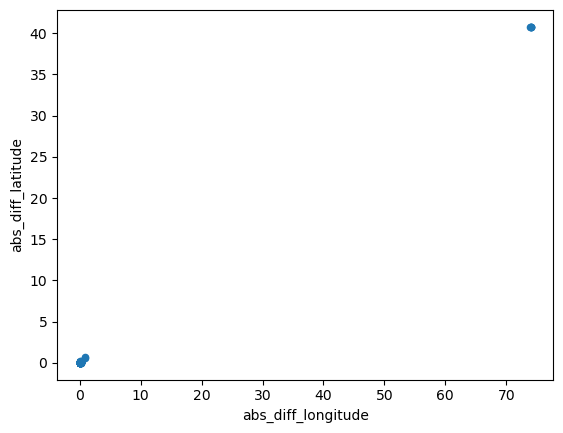

In [12]:
%%time
plot = train_df.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

70 degrees longitude seems a bit too high...

In [13]:
%%time
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df))

Old size: 9999926
New size: 9979189
CPU times: user 612 ms, sys: 368 ms, total: 979 ms
Wall time: 977 ms


#### Get training features and results

In [14]:
%%time
import numpy as np

# using the travel vector, plus a 1.0 for a constant bias term.
def get_input_matrix(df):
    return np.column_stack((df.abs_diff_longitude, df.abs_diff_latitude, np.ones(len(df))))

train_X = get_input_matrix(train_df)
train_y = np.array(train_df['fare_amount'])

print(train_X.shape)
print(train_y.shape)

(9979189, 3)
(9979189,)
CPU times: user 98.6 ms, sys: 194 ms, total: 293 ms
Wall time: 291 ms


#### Train a simple linear model using Numpy

In [18]:
%%time
# The lstsq function returns several things, and we only care about the actual weight vector w.
(w, _, _, _) = np.linalg.lstsq(train_X, train_y, rcond = None)
print(w)

[148.48697     74.73346376   6.41299165]
CPU times: user 836 ms, sys: 682 ms, total: 1.52 s
Wall time: 774 ms


#### Make prediction on our test set and measure performance

In [15]:
test_df =  pd.read_csv('gs://obd-dask23/test_cleaned.csv', storage_options={'token': 'anon'})
test_df.dtypes

Unnamed: 0              int64
key                    object
fare_amount           float64
pickup_datetime        object
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
passenger_count         int64
abs_diff_longitude    float64
abs_diff_latitude     float64
dtype: object

In [16]:
add_travel_vector_features(test_df)
test_X = get_input_matrix(test_df)

In [19]:
test_y_predictions = np.matmul(test_X, w).round(decimals = 2)

In [20]:
test_y_ref = test_df.fare_amount

In [21]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y_ref, test_y_predictions, squared=False)

6.428124794105603

You should get sabout 6.43 of RMSE, not bad, but we can do better.

<span style="color:#EB5E0B;font-style:italic">

### Some questions on this first Analysis

- What is the most expensive part of the analysis, the one that takes the most time (see the %%time we used above)?
</span>

In [ ]:
#Loading the dataframe with pandas was the most expensive part of this analysis, since it lasted about 46 seconds (wall time, and 35 seconds on CPU)

<span style="color:#EB5E0B;font-style:italic">
    
- Try to load the whole dataset with Pandas and comment what happens. Can you explain why?
</span>

In [ ]:
%%time
#train_df =  pd.read_csv('gs://obd-dask23/train.csv', storage_options={'token': 'anon'})

In [ ]:
#The input data is just too big to fit inside memory. That is why our kernel crashed.
#I commented the line above to avoid another crash by accident

# Processing our data set using Dask

Dask will help us process all the input data set at once. It is really useful when input data is too big to fit in memory. In this case, it can stream the computation by data chunks on one computer, or distribute the computation on several computers.

This is what we'll do next!

### Start an appropriately sized Dask cluster for our analysis

We'll need a Dask cluster to pre process the data and distribute some learning, the following code starts one in our K8S infrastructure.

**Be sure to have any other Dask cluster shutdown.**

In [2]:
from dask_gateway import Gateway
gateway = Gateway()
clusters=gateway.list_clusters()
for cluster in clusters:
    gateway.stop_cluster(cluster.name)

In [3]:
cluster = gateway.new_cluster(worker_cores=1, worker_memory=3.0)
cluster

__Please click on the Dashboard link above, it will help you a lot!__

In [9]:
cluster.scale(30)

In [5]:
client = cluster.get_client()

### Launch some computation, what about Pi?

Just to check our cluster is working!

We'll use Dask array, a Numpy extension for this, we'll also use it later on for the Machine Learning part of this evaluation.

In [19]:
%%time
import dask.array as da

sample = 10_000_000_000  # <- this is huge!
xxyy = da.random.uniform(-1, 1, size=(2, sample))
norm = da.linalg.norm(xxyy, axis=0)
summ = da.sum(norm <= 1)
insiders = summ.compute()
pi = 4 * insiders / sample
print("pi ~= {}".format(pi))

pi ~= 3.1415999876
CPU times: user 807 ms, sys: 119 ms, total: 927 ms
Wall time: 1min 55s


## Now, access the data of our BE using Dask

We'll use Dask Dataframe, a distributed version of Pandas Dataframe.

Remember, Dask shares the same API as Pandas.

See https://docs.dask.org/en/latest/dataframe.html.

<br>
<span style="color:#EB5E0B;font-style:italic">
So instead of using Pandas to load the dataset, just use the equivalent dask method from dask.dataframe.

- Fill the following cell (the second one) with the appropriate code to read the data using Dask.
</span>

In [27]:
import dask.dataframe as dd

In [28]:
%%time
train_df=dd.read_csv('gs://obd-dask23/train.csv', storage_options={'token': 'anon'})

CPU times: user 429 ms, sys: 34.3 ms, total: 463 ms
Wall time: 660 ms


In [22]:
train_df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
npartitions=89,,,,,,,,
,string,float64,string,float64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


<span style="color:#EB5E0B;font-style:italic">

### Some questions about this data loading

- That was fast for several gigabytes, wasn't it? Why is this, did we really load all the data?
- Why the returned dataframe looks empty?
- See the number of partitions described above? What does it correspond to? (hint, look at the blocksize parameter from https://docs.dask.org/en/latest/generated/dask.dataframe.read_csv.html). You might also get a more precise idea of what this number corresponds to with the next code execution.
</span>

**ANSWER**

Dask adopt a lazy evaluation model. It means that when you load data into a Daska df, Daks doesn't immediately load the data into memory. Instead, it creates a task graph that describes the operation needed to load the data. The graph is only executer when you explicitly ask for the result of a computation (by calling .compute()). That's why the dataframe look empty. In a sense however, we really loaded the data, since Dask has prepared a plan to load the data when needed. But no in the sense that the data is not yet in memory. The loading only happens when necessary during computation.

When we have loaded our data into a Dask df, it got divided into smaller partitions (chunks), each corresponding to a block of data. These partitions allow Dask to parallelize computations accross the dataset, making it suitable for distributed and out-of-core processing. 

## Little warm up: Analyzing our data to better understand it

<span style="color:#EB5E0B;font-style:italic">

- First, how many records do we have? (hint, in python, len() works for almost any object).
</span>

In [29]:
%%time
len(train_df)
#It looks like we have 55 413 856 records

CPU times: user 120 ms, sys: 15.2 ms, total: 135 ms
Wall time: 2min 40s


55413856

<span style="color:#EB5E0B;font-style:italic">
    
- What did happend when counting record of our Dask dataframe (as opposed to with only the `read_csv` call? Remember with the Spark tutorial: transformations and actions... Same kind of concepts exist in Dask. Just look at the Dask Dashboard!
</span>

**ANSWER**

When you count the number of records in a Dask DataFrame, you're moving beyond just setting up a computation (as with the read_csv call) and actually triggering the computation to run. This distinction between setting up computations and executing them is indeed similar to the concept of transformations and actions in Spark. In Dask, this is often referred to as the difference between lazy evaluation and eager execution. 

**Transformations** are operations that don't compute results immediately, but instead build up a task graph (like we did when calling read_csv, but also filtering, grouping...). These operations are lazy, like we previously explained, because they don't trigger any actual data processing, they just prepare the computation plan.

**Actions** are operations that trigger computation and produce results (such as .compute()). When performing actions in Dask, it executes the task graph previously built by the transformation and then actually process the data.

Looking at our dashboard, we see that calling len(train_df) did load the necessary data into memory, processing it in partitions to keep memory usage manageable, then executing the taks graph, then aggregating the count results of the different parts (this operation is also part of the task graph), and finally returning the result (the number of record in the dataframe

<span style="color:#EB5E0B;font-style:italic">
    
- Compare the time of this computation to the time of loading a subset of the Dataset with Pandas. Was it fast enough considering the number of workers we have?
    
I recommend trying to calculate an estimation of the time it would take with Pandas to read the entire dataset, and **total processing** time (not only the walltime) it took for every dask workers.
</span>

**ANSWER** 

In order to load 20% of the dataset earlier, it took us about 45 seconds with walltime. If we multiply it by 5, we estimate it would have taken us 225 seconds, or 3.75 minutes to load the full dataset.
For the Dask dataset, we look at the total processing time (summing user and sys), which brings us to 60s. We used 10 workers. Theoretically, this operation should execute in 225/10=25 seconds, but that did not happen. Why ? Because of what is called *Overhead*, meaning the theoretical perfect speed-up is never attained because of task scheduling, data partitioning, aggregating and communication between workers.
Even if we did not speed-up the computation by a factor 10, we did it with a factor 2, which is still pretty good. Maybe we could have increased a little bit the number of worker to improve performance (but this is not sure). 

Let's have a look at some data:

In [30]:
%%time
train_df.head()

CPU times: user 11 ms, sys: 1.32 ms, total: 12.3 ms
Wall time: 3.02 s


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2014-10-12 23:47:39.0000002,9.00,2014-10-12 23:47:39 UTC,-73.973863,40.764248,-73.986874,40.736618,1
1,2012-08-17 22:34:00.000000118,4.10,2012-08-17 22:34:00 UTC,-73.997062,40.722330,-73.997642,40.729135,1
2,2011-05-17 13:11:00.000000229,9.70,2011-05-17 13:11:00 UTC,-74.000002,40.727167,-73.984253,40.753135,2
3,2015-03-08 09:10:25.0000005,57.33,2015-03-08 09:10:25 UTC,-74.004166,40.737652,-73.795753,40.644497,2
4,2010-03-27 19:54:44.0000001,7.30,2010-03-27 19:54:44 UTC,-73.990309,40.751309,-73.980597,40.761481,1


<span style="color:#EB5E0B;font-style:italic">
    
- Why was it faster than counting all the records above? 
- What did we actualy read? You might want to look at the Dashboard for some hinsights. Remember that Dask laziness is not only about transformations and actions, but optimizing the computations needed.
</span>

**ANSWER**

It was much faster than counting all the records ! When looking at the dashboard, we can see that only one worker was called with a to_pyarrow_string task. It is a method known to convert different objects (such as ou dataset first 5 rows) into string in a noticable really fast why. This method was probably chosen on purpose in order to accelerate the computation, highlighting the optimization of computation at all levels. When looking at this task into details, we notice that in the end, strings ar finally casted back to their original type with the .astype() method.
Also, it is pretty clear that loading only the first five lines of the dataset should be much faster than crawling all its records like the len() method forced us to do. We took advantage of the partition into chunks in order to optimize computation.

<span style="color:#EB5E0B;font-style:italic">
    
- Let's compute the mean of the fare amount given the passengers count, **as we've done with Pandas above**. Please fill the blank. (hint: Dask is the same as pandas, but often with a `compute()` call at the end)
</span>

In [31]:
%%time
train_df.groupby(train_df.passenger_count).fare_amount.mean().compute()

CPU times: user 78.1 ms, sys: 10.7 ms, total: 88.7 ms
Wall time: 1min 8s


passenger_count
0       9.015400
1      11.216398
2      11.838426
3      11.540684
4      11.766121
5      11.208482
6      12.126306
8      29.981111
208     8.975000
51      9.300000
129     8.900000
7      31.788667
9      36.993043
34     13.300000
49      2.500000
Name: fare_amount, dtype: float64

Wow, ever seen a cab with more than **200 people**?? Americans are crazy. And it's cheap...

<br>

<span style="color:#EB5E0B;font-style:italic">

- This computation is slow, especially compared with Pandas, why? (Look a the Dashboard, again).
- Which part of the computation is slow, look at the Dashboard to see the name of the tasks. Hint, this is the same as Pandas.
</span>

**ANSWER**

Dask breaks down computation into tasks that can be executed in parallel. However, scheduling and managing these tasks introduce overhead (as we specified before). For operations that are not highly compute-intensive, the overhead of task management can outweight the benefits of parallel execution. There's an inherent cost in moving data between worked, this is particularly important for group-by operations, which may require significant data shuffling to group records by keys before computing the mean. Pandas operates in-memory and is highly optimized for single-threaded performance. For datasets that fit into memory, Pandas can often perform computations like group-by and mean very quickly. The simplicity of operating in a single process without the need to manage parallel tasks or handle data distribution can make Pandas faster for these types of operations.

When looking at the dashboard, our hypothese is confirmed : the worst-performing (taking longer) task is the .getItem() method. The groupby-count-chunk and groupby-sum-chunk did only take 2 seconds, while the getItem did take 272 seconds (partitionned between all workers). 

<span style="color:#EB5E0B;font-style:italic">
    
- How could we optimize the next computations, using which Dask method? Same as Spark...
- Where will be the data at the end of the computation triggered by this call?
</span>

**ANSWER**

To optimize computations in Dask, especially for operations executed repeatedly, or requiring significant data shuffling ( such as group-by), we can use the persist method. This approach is similar to what we did previously with Spark, and can significantly improve performance for iterative computation or when needing to access the same dataset multiple times. 
The persist method evaluates the computation up to the current point, and keeps the resulting dataset in memory (or on disk) accross the cluster. After calling persist, the dataset will be kept in distributed memory accross the cluster's workers, and subsequent operations (transformations, actions), will be much faster. Any future computation of the persisted data will start from the in-memory state of the data. 

In [95]:
train_df=dd.read_csv('gs://obd-dask23/train.csv', storage_options={'token': 'anon'}).persist()

<span style="color:#EB5E0B;font-style:italic">
    
- Look at the Dashboard at what is happening beind the scene.
    
Wait for the end of this call on the Dashboard, then try again the previous computation on fare_amout.mean():
</span>

In [34]:
%%time
train_df.groupby(train_df.passenger_count).fare_amount.mean().compute()

CPU times: user 78.5 ms, sys: 9.56 ms, total: 88 ms
Wall time: 28.8 s


passenger_count
0       9.015400
1      11.216398
2      11.838426
3      11.540684
4      11.766121
5      11.208482
6      12.126306
8      29.981111
208     8.975000
51      9.300000
129     8.900000
7      31.788667
9      36.993043
34     13.300000
49      2.500000
Name: fare_amount, dtype: float64

Much better isn't it?

## Let's do some preprocessing of our data to clean it up and add some features

<br>

<span style="color:#EB5E0B;font-style:italic">
- You'll need to do the same operations as in pandas, we just need to call compute when needing a result, and not compute when building our dataframe transformations.
</span>

<span style="color:#EB5E0B;font-style:italic">

#### Cleaning up

- Is there some null values in our data?
</span>

In [13]:
print(train_df.isnull().sum().compute())

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64


<span style="color:#EB5E0B;font-style:italic">
    
- Yep! We must get rid of them...
</span>

In [96]:
%%time
train_df = train_df.dropna(how = 'any')

CPU times: user 7.74 ms, sys: 1.92 ms, total: 9.66 ms
Wall time: 8.64 ms


In [59]:
print(train_df.isnull().sum().compute())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


#### Adding features

<span style="color:#EB5E0B;font-style:italic">

- As with Pandas above, add the latitude and longitude distance vector with a function call
</span>

In [97]:
## Answer needed here. We define a function here, cause we'll need to apply it on our test dataframe too later on!
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
add_travel_vector_features(train_df)

A quick look at our Dataframe to check things

In [18]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
0,2014-10-12 23:47:39.0000002,9.00,2014-10-12 23:47:39 UTC,-73.973863,40.764248,-73.986874,40.736618,1,0.013011,0.027630
1,2012-08-17 22:34:00.000000118,4.10,2012-08-17 22:34:00 UTC,-73.997062,40.722330,-73.997642,40.729135,1,0.000580,0.006805
2,2011-05-17 13:11:00.000000229,9.70,2011-05-17 13:11:00 UTC,-74.000002,40.727167,-73.984253,40.753135,2,0.015749,0.025968
3,2015-03-08 09:10:25.0000005,57.33,2015-03-08 09:10:25 UTC,-74.004166,40.737652,-73.795753,40.644497,2,0.208412,0.093155
4,2010-03-27 19:54:44.0000001,7.30,2010-03-27 19:54:44 UTC,-73.990309,40.751309,-73.980597,40.761481,1,0.009712,0.010172


<span style="color:#EB5E0B;font-style:italic">
    
- Now let's quickly plot a subset of our travel vector features to see its distribution. Use dask.dataframe.sample() to get about 1 percent of the rows, and get it back with compute and plot as we've done it with Pandas
</span>

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.44 µs


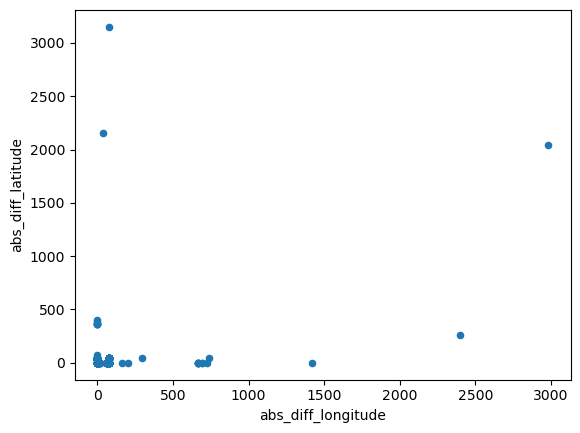

In [37]:
import matplotlib.pyplot as plt

%time

# Sample approximately 1% of the data
sampled_df = train_df.sample(frac=0.01).compute()

plot = sampled_df.plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

Wow, looks like we have some strange values here: more than 1000° of distance... There's a problem somewhere.

<br>

<span style="color:#EB5E0B;font-style:italic">
- Just get rid of the extreme values, we should keep only values inside the city wall or so. Like with Pandas above...
</span>

In [98]:
%%time

train_df = train_df[(train_df.abs_diff_longitude < 5) & (train_df.abs_diff_latitude < 5)]

CPU times: user 4.74 ms, sys: 60 µs, total: 4.8 ms
Wall time: 4.63 ms


<span style="color:#EB5E0B;font-style:italic">

- you can do another plot like above with the filtered values if you like.
</span>

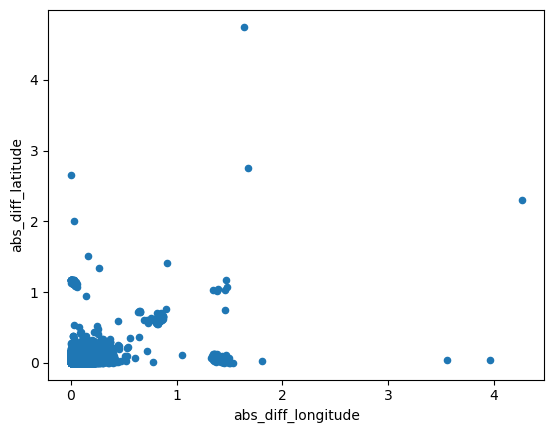

In [39]:
sampled_df = train_df.sample(frac=0.01).compute()

plot = sampled_df.plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

Ok, let's see some statistics on our Dataset. The describe() function inherited from Pandas compute a lot of statistics on a dataframe.

In [40]:
train_df.describe().compute()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
count,5.529894e+07,5.529894e+07,5.529894e+07,5.529894e+07,5.529894e+07,5.529894e+07,5.529894e+07,5.529894e+07
mean,1.133683e+01,-7.257290e+01,3.995280e+01,-7.257205e+01,3.995314e+01,1.685440e+00,2.251316e-02,2.110157e-02
std,2.071499e+01,1.094742e+01,7.044005e+00,1.094731e+01,7.044055e+00,1.326790e+00,3.854502e-02,2.903143e-02
min,-3.000000e+02,-3.440696e+03,-3.488080e+03,-3.440696e+03,-3.488080e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,-7.399201e+01,4.073514e+01,-7.399136e+01,4.073421e+01,1.000000e+00,5.827000e-03,6.606000e-03
50%,8.500000e+00,-7.398174e+01,4.075281e+01,-7.398010e+01,4.075332e+01,1.000000e+00,1.244900e-02,1.387000e-02
75%,1.250000e+01,-7.396703e+01,4.076725e+01,-7.396365e+01,4.076821e+01,2.000000e+00,2.370300e-02,2.697000e-02
max,9.396336e+04,3.456223e+03,3.378013e+03,3.456223e+03,3.378013e+03,2.080000e+02,4.989833e+00,4.991325e+00


<span style="color:#EB5E0B;font-style:italic">
    
- Find some values (at least two) that still looks odd to you in the table above.
</span>

**ANSWER**

The minimum fare is negative, and the maximum fare is 93,963$, which is unlikely. Also, the min_passenger count is 0, which is also unlikely for a taxi. After doing some research, normal longitudes in New-York should be situated between -74.3 and -73.7, and normal latitudes between 40.5 and 40.9. Let's clean all of this. 


In [1]:
def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the Haversine distance between two points given their longitude and latitude.
    """
    # Earth radius in kilometers
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    lon1_rad = np.radians(lon1)
    lat1_rad = np.radians(lat1)
    lon2_rad = np.radians(lon2)
    lat2_rad = np.radians(lat2)
    
    # Calculate differences in longitude and latitude
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    # Calculate Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    
    return distance

In [6]:
import dask.dataframe as dd
from dask_ml.preprocessing import StandardScaler
import numpy as np

train_df = dd.read_csv('gs://obd-dask23/train.csv', storage_options={'token': 'anon'}).persist()

#Drop NA values
train_df = train_df.dropna(how='any')

#load and convert Data time
train_df['pickup_datetime'] = dd.to_datetime(train_df['pickup_datetime'], utc=True)
# Extract hour and month
train_df['hour_of_day'] = train_df['pickup_datetime'].dt.hour
train_df['day_of_week'] = train_df['pickup_datetime'].dt.dayofweek  # 0 for monday, 6 for sunday
train_df['month'] = train_df['pickup_datetime'].dt.month

# Définition de la fonction add_travel_vector_features
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

train_df = train_df[(train_df.abs_diff_longitude < 5) & (train_df.abs_diff_latitude < 5)]

# Supprimer les valeurs aberrantes pour le tarif et le nombre de passagers
train_df = train_df[(train_df['fare_amount'] > 0) & (train_df['fare_amount'] <= 1000)]
train_df = train_df[train_df['passenger_count'] > 0]

# Extract hour of the day and month from pickup datetime
train_df['pickup_datetime'] = dd.to_datetime(train_df['pickup_datetime'])
train_df['hour_of_day'] = train_df['pickup_datetime'].dt.hour
train_df['month'] = train_df['pickup_datetime'].dt.month

# Restrain values of lat/long to NYC (googled it)
train_df = train_df[(train_df['pickup_longitude'] >= -75.3) & (train_df['pickup_longitude'] <= -72.7)]
train_df = train_df[(train_df['pickup_latitude'] >= 39.5) & (train_df['pickup_latitude'] <= 41.5)]
train_df = train_df[(train_df['dropoff_longitude'] >= -75.3) & (train_df['dropoff_longitude'] <= -72.7)]
train_df = train_df[(train_df['dropoff_latitude'] >= 39.5) & (train_df['dropoff_latitude'] <= 41.5)]

# Calculate distances with haversine function
train_df['distance'] = haversine_distance(train_df['pickup_longitude'], train_df['pickup_latitude'], train_df['dropoff_longitude'], train_df['dropoff_latitude'])

# Normalize numerical features
numerical_features = ['fare_amount', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance', 'hour_of_day', 'month']
scaler = StandardScaler()
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])

# Add non linear features
positive_numerical_features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance']

def square_positive(x):
    return np.where(x > 0, x ** 2, x)

for feature in positive_numerical_features:
    train_df[f'{feature}_squared'] = train_df[feature].map_partitions(square_positive)

# Print statistics
print(train_df.describe().compute())


        fare_amount      pickup_datetime  pickup_longitude  pickup_latitude  \
count  5.406130e+07             54061296      5.406130e+07     5.406130e+07   
min   -1.167535e+00  2009-01-01 00:00:27     -3.383909e+01    -3.887521e+01   
25%   -5.497328e-01  2010-08-17 21:00:15     -4.359663e-01    -4.481609e-01   
50%   -2.918854e-01  2012-03-25 00:06:09     -1.756986e-01     8.092874e-02   
75%    1.206704e-01  2013-10-23 16:07:03      1.778943e-01     5.256596e-01   
max    9.970134e+01  2015-06-30 23:59:54      3.242341e+01     2.352404e+01   
mean   2.621296e-17                 <NA>     -7.779391e-14    -2.807909e-14   
std    1.000000e+00                 <NA>      1.000000e+00     1.000000e+00   

       dropoff_longitude  dropoff_latitude  passenger_count   hour_of_day  \
count       5.406130e+07      5.406130e+07     5.406130e+07  5.406130e+07   
min        -3.456088e+01     -3.572656e+01    -5.261134e-01 -2.073170e+00   
25%        -4.490522e-01     -4.429558e-01    -5.261134e-

<span style="color:#EB5E0B;font-style:italic">
    
- Do you think we could parallelize things better for any of our computation or data access? (It's a trap).
</span>

**ANSWER**

Over-parallelization can introduce unnecessary overhead and complexity without proportional benefits. The goal should be to find a balance that leverages parallelism effectively while minimizing overhead and efficiently utilizing available resources.

<span style="color:#EB5E0B;font-style:italic">
    
### BONUS Questions (you don't have to do this, just go back to it if you want to improve, skip it at first)

Some other questions to practice

- Can you see a correlation between the fare amount and the dropoff latitude? Answer by doing a dask dataframe computation.

First you'll need to round the dropoff latitude to have some sort of categories using Series.round() function.

Then, just group_by this new colon to have some answer (and don't forget to compute to get the results).
</span>

In [91]:
import dask.dataframe as dd

train_df['rounded_dropoff_latitude'] = train_df['dropoff_latitude'].round()

result = train_df.groupby('rounded_dropoff_latitude')['fare_amount'].mean()

computed_result = result.compute()

computed_result

rounded_dropoff_latitude
40.0    17.286603
41.0    11.328747
42.0     9.520000
Name: fare_amount, dtype: float64

OK, this don't give a lot of insights, but it looks like we've got some strange values somewhere!

<br>

<span style="color:#EB5E0B;font-style:italic">
- Let's just have a look of non extreme values, so probably some records at the middle of the results.
We need first to sort the resulting series by index before looking at the middle of it.
</span>

In [76]:
# Sort the resulting series by index
sorted_result = computed_result.sort_index()

# Let's look at the middle values of the sorted series
middle_index = len(sorted_result) // 2
middle_values = sorted_result.iloc[middle_index - 5: middle_index + 5]

print(middle_values)

rounded_dropoff_latitude
23.0    10.000000
24.0     8.766667
25.0     5.800000
26.0    18.325000
27.0     6.333333
28.0     9.500000
29.0     8.320000
30.0    11.035294
31.0     8.190000
32.0     9.055556
Name: fare_amount, dtype: float64


In [50]:
len(train_df)

53971981

OK, this is not really useful, but it's an exercise!

## Training a model in a distributed way

Let's begin with a linear model that we can distributed with Dask ML.

### Building our feature vectors

Here again define a method so that we can use it later for our test set evaluation.

<br>

<span style="color:#EB5E0B;font-style:italic">
    
- Just do the same as with the Pandas example by defining a get_input_matrix(df) function. But this time you'll generate a dask array (not numpy) using `to_dask_array(lengths=True)` method on the dataframe object instead of `np.column_stack` (look a bit a dask docs in order to find how to use this method). You should do a method that generate the X input features dask array, and also the same with y training results. You can do just one method that return both (return X, y). 
- It is a good idea to persist() arrays in memory in or after the call.
- This time, we'll add the feature 'passenger_count' in addition to the distance vectors, one more feature! So X must have 3 columns.
</span>

In [7]:
%time
import dask.dataframe as dd
import dask.array as da

def get_input_matrix(df):
    features_df = df[['abs_diff_longitude', 'abs_diff_latitude', 'passenger_count']]
    X = features_df.to_dask_array(lengths=True)
    y = df['fare_amount'].to_dask_array(lengths=True)
    X = X.persist()
    y = y.persist()
    return X, y

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.4 µs


Then we get the values, and display train_X to have some insights of its size and chunking scheme.

In [11]:
%time
train_X, train_y = get_input_matrix(train_df)
train_X

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 12.6 µs


Task exception was never retrieved
future: <Task finished name='Task-1468' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1527' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1472' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/pyth

KeyboardInterrupt: 

### Distributed training a Linear model

Be careful, this can take time, try first with few iterations (Use max_iter = 5 as a kwarg to LinearRegression constructor).

see https://ml.dask.org/glm.html  
and https://ml.dask.org/modules/generated/dask_ml.linear_model.LinearRegression.html#dask_ml.linear_model.LinearRegression

<br>

<span style="color:#EB5E0B;font-style:italic">
    
- Train a LinearRegression model from dask_ml.linear_model on our inputs
</span>


In [ ]:
## Answer needed here
%time
from dask_ml.linear_model import LinearRegression
model = LinearRegression(max_iter=5)
model.fit(train_X, train_y)

## Evaluating our model


#### First we should load the test set.

In [ ]:
test_df = dd.read_csv('gs://obd-dask23/test_cleaned.csv', storage_options={'token': 'anon'}).persist()

# Delete na values
test_df = test_df.dropna(how='any')

# convert to datetime format
test_df['pickup_datetime'] = dd.to_datetime(test_df['pickup_datetime'], utc=True)

# Extract day, hour, month
test_df['hour_of_day'] = test_df['pickup_datetime'].dt.hour
train_df['day_of_week'] = train_df['pickup_datetime'].dt.dayofweek  # 0 for monday, 6 for sunday
test_df['month'] = test_df['pickup_datetime'].dt.month

# Add travel vectors
add_travel_vector_features(test_df)

# Calculate Haversine distance
test_df['distance'] = haversine_distance(test_df['pickup_longitude'], test_df['pickup_latitude'], test_df['dropoff_longitude'], test_df['dropoff_latitude'])

# Normalize
test_df[numerical_features] = scaler.transform(test_df[numerical_features])

# Nonlinear features
for feature in positive_numerical_features:
    test_df[f'{feature}_squared'] = test_df[feature].map_partitions(square_positive)

print(test_df.describe().compute())


Adding our features to the test set and getting our feature array

In [122]:
add_travel_vector_features(test_df)
test_X, test_y = get_input_matrix(test_df)
test_X

dask.array<values, shape=(9773, 3), dtype=float64, chunksize=(9773, 3), chunktype=numpy.ndarray>

We can use the score method inherited from Scikit learn, it gives some hints on the model performance (but our scoring board will be on RMSE). Even if for linear models, score if often low.

In [125]:
model.score(test_X, test_y)

0.6438779855103591

In [49]:
model.predict(test_X).compute()

array([31.94932154, 10.4277079 , 13.41553028, ...,  8.44994263,
       10.06444395,  7.22275752])

#### Compute the RMSE

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation

In [126]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y.compute(), model.predict(test_X).compute(), squared=False)

0.5835034667820065

<span style="color:#EB5E0B;font-style:italic">
    
- What RMSE did you get? Compare it to the Pandas only computation.
</span>

In [ ]:
#We get a 6.41 RMSE, this is not bad at all considering 5 iterations only.

# Distributed XGboost (optionnal, you can skip it at first)

Just use the documentation here https://xgboost.readthedocs.io/en/stable/tutorials/dask.html#overview to train a model on this dataset using xgboost.

<br>
<span style="color:#EB5E0B;font-style:italic">
    
- Just copy/paste the example (dtrain = ..., output = ...), and modify some input variables.
- Then make a prediction (but don't forget to use your test set, not as in the prediction = ... example from the Xgboost doc).
- Compute the mean square error on it.
</span>

In [52]:
import xgboost as xgb
dtrain = xgb.dask.DaskDMatrix(client, train_X, train_y)
output = xgb.dask.train(
    client,
    {"verbosity": 2, "tree_method": "hist", "objective": "reg:squarederror"},
    dtrain,
    num_boost_round=4,
    evals=[(dtrain, "train")],
)

In [53]:
dtest = xgb.dask.DaskDMatrix(client, test_X, test_y)
prediction = xgb.dask.predict(client, output, dtest)

In [54]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y.compute(), prediction.compute(), squared=False)

5.062154804026349

## Use Dask to scale computation on Hyper Parameter Search

As seen above, Dask is well suited to distribute Data and learn a model on a big Data set. However, not all the models can be trained in parallel on sub chunks of Data. See https://scikit-learn.org/stable/computing/scaling_strategies.html for the compatible models of Scikit learn for example.

Dask can also be used to train several models in parallel on small datasets, this is what we'll try now.

We will just take a sample of the training set, and try to learn several models with different hyper parameters, and find the best one.

Dask Hyper parameter search : https://ml.dask.org/hyper-parameter-search.html.

First we'll take a small subset of the Data, 5% is a maximum if we want to avoir memory issues on our workers and have appropriate training times. You can try with less if the results are still good.

In [83]:
#Take a sample of the input data, get it as pandas dataframe
train_sample_df = train_df.sample(frac=0.05, random_state=270120)
# Get feature vectors out of it
train_sample_X, train_sample_y = get_input_matrix(train_sample_df)

In order to optimize things, we can also change the type of the features to more appropriate and small types.

We also need to use Numpy arrays, so we'll gather the result from Dask to local variable.

In [84]:

train_sample_X = train_sample_X.astype('float32').compute()
train_sample_y = train_sample_y.astype('float32').compute()
train_sample_X

array([[0.031015  , 0.02671   , 1.        ],
       [0.00778   , 0.01741   , 2.        ],
       [0.0091    , 0.010142  , 1.        ],
       ...,
       [0.19846   , 0.092866  , 1.        ],
       [0.028012  , 0.032991  , 1.        ],
       [0.00333405, 0.00214005, 1.        ]], dtype=float32)

What size is our dataset ?

In [46]:
import sys
sys.getsizeof(train_sample_X)

33179432

About 32MB, this is still quite a big dataset for standard machine learning.

<span style="color:#EB5E0B;font-style:italic">

- Now, just use hyper parameter search Dask API to distribute the search. You can either use joblib integration with Sklearn or dask_ml directly. 

**Be careful: do not use model too long to train, and limit their complexity at first or the combinations of hyper parameters you'll use. Hint, start first with a simple LinearModel like SGDRegressor and not more than 10 iterations per model.**
</span>

So start with something like:

- RandomizedSearchCV https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html, with cv=2, n_iter=50, verbose=10
- With sklearn.linear_model.SGDRegressor with max_iter=20
- Use this parameter space:
```python
from scipy.stats import uniform, loguniform
param_space = {
    "average": [True, False],
    'penalty': ['l2', 'l1', 'elasticnet'],
    "alpha": loguniform(1e-5, 1e-1),
    "learning_rate": ["invscaling", "adaptive"],
    "power_t": uniform(0, 1),
}
```
- If you chose sklearn API, you want to import joblib, and use `with joblib.parallel_backend('dask'):` before fitting your model.
- If you chose dask_ml API, https://ml.dask.org/hyper-parameter-search.html#basic-use, you'll don't need the with syntax, but just the correct imports: from dask_ml.model_selection import RandomizedSearchCV

In [ ]:
%%time
## Answer needed here (with sklearn API)

In [60]:
%%time
from dask_ml.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from scipy.stats import uniform, loguniform

# Define the parameter space
param_space = {
    "average": [True, False],
    'penalty': ['l2', 'l1', 'elasticnet'],
    "alpha": loguniform(1e-5, 1e-1),
    "learning_rate": ["invscaling", "adaptive"],
    "power_t": uniform(0, 1),
}

# Initialize the SGDRegressor
model = SGDRegressor(max_iter=20)

# Set up the randomized search with cross-validation
search = RandomizedSearchCV(
    model,
    param_space,
    n_iter=50,
    cv=2,
    random_state=42
)

# Perform the search on the sampled data
# Assuming train_sample_X and train_sample_y are already computed and converted to pandas DataFrame/series
search.fit(train_sample_X, train_sample_y)

# Results
print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)


/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 42.20 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 42.19 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Best parameters: {'alpha': 6.410277188110155e-05, 'average': False, 'learning_rate': 'invscaling', 'penalty': 'l2', 'power_t': 0.3143559810763267}
Best score: 0.503800491630873
CPU times: user 570 ms, sys: 216 ms, total: 785 ms
Wall time: 1min 36s


In [61]:
search.score(test_X, test_y)

0.5477293631050179

In [62]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, search.predict(test_X), squared=False)

6.396363262943413

<span style="color:#EB5E0B;font-style:italic">

- So how does this result compare to the previous one we got with a distributed leaning with a linear model on all the dataset?
    
</span>

**ANSWER** 

Our RMSE is slightly better, like the accuracy, but the difference is not very shocking. Maybe we should run a more ambitious GridSearch and increase the number of iterations to see a real difference. XGBoost, however, was much more efficient. 

<span style="color:#EB5E0B;font-style:italic">

- Try with https://ml.dask.org/modules/generated/dask_ml.model_selection.HyperbandSearchCV.html#dask_ml.model_selection.HyperbandSearchCV instead of RandomizedSearchCV.
    
You'd prefer to use dask_ml.model_selection.HyperbandSearchCV (instead of joblib). And just need to change n_iter to max_iter, and remove another arg.
    
</span>

In [47]:
%%time
from dask_ml.model_selection import HyperbandSearchCV
from sklearn.linear_model import SGDRegressor

model = SGDRegressor(max_iter=20)
#Unfortunately, uniform distribution are not supported here
param_space = {
    'average': [True, False],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-5, 1e-3, 1e-1],  
    'learning_rate': ['invscaling', 'adaptive'],
    'power_t': [0.1, 0.3, 0.5] }

search = HyperbandSearchCV(
    model,
    param_space,
    max_iter=50,
    patience=True,  
    random_state=42
)

# Fit the model
search.fit(train_sample_X, train_sample_y)
print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 42.19 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Best parameters: {'power_t': 0.1, 'penalty': 'l1', 'learning_rate': 'adaptive', 'average': True, 'alpha': 1e-05}
Best score: 0.5114013035648637
CPU times: user 881 ms, sys: 577 ms, total: 1.46 s
Wall time: 51.3 s


In [48]:
search.score(test_X, test_y)

0.5430723048471259

In [49]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, search.predict(test_X), squared=False)

6.429210792045596

<span style="color:#EB5E0B;font-style:italic">
    
- OK, Linear models are what they are, we'll try to do better with Random forest! https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
    
Return to RandomizedSearchCV for now.

Caution: use limited trees, small number of estimators < 10 and max_depth < 40 at first
</span>

For example:

```python
param_space = {
'n_estimators': range(4,10),
'max_depth': range(10,40),
}
```

In [51]:
from dask_ml.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import dask.array as da

# Define the parameter space
param_space = {
    'n_estimators': range(4, 10),  # Fewer estimators for quicker iterations
    'max_depth': range(10, 40),    # Limited depth to prevent overly complex models initially
}

# Initialize the model
model = RandomForestRegressor()

# Setup Randomized Search with cross-validation
search = RandomizedSearchCV(
    model,
    param_space,
    n_iter=50,  
    cv=2,
    random_state=42,
)

search.fit(train_sample_X, train_sample_y)

# Print the results
print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)


/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 42.19 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 42.19 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Best parameters: {'n_estimators': 7, 'max_depth': 11}
Best score: 0.7440967136079293


<span style="color:#EB5E0B;font-style:italic">
    
- If you did not used joblib, try it now.

What do you observe when training RandomForest tree on Dask parallelization Dashboard with joblib? Can you explain why there are so many tasks?
</span>

In [55]:
%%time
from dask.distributed import Client
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from joblib import parallel_backend

# Define the parameter space
param_space = {
    'n_estimators': range(4, 10), 
    'max_depth': range(10, 40),
}

model = RandomForestRegressor()
search = RandomizedSearchCV(
    model,
    param_space,
    n_iter=50,
    cv=2,
    random_state=42,
    verbose=10
)

# Use Dask's Joblib backend to distribute the computation
with parallel_backend('dask'):
    search.fit(train_sample_X, train_sample_y)

# Print the results
print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)


Fitting 2 folds for each of 50 candidates, totalling 100 fits
Best parameters: {'n_estimators': 7, 'max_depth': 11}
Best score: 0.7446222701628291
CPU times: user 1.48 s, sys: 448 ms, total: 1.92 s
Wall time: 12min 34s


In [127]:
from sklearn.ensemble import RandomForestRegressor
#Take a sample of the input data, get it as pandas dataframe
train_sample_df = train_df.sample(frac=0.05, random_state=270120)
# Get feature vectors out of it
train_sample_X, train_sample_y = get_input_matrix(train_sample_df)
train_sample_X = train_sample_X.astype('float32').compute()
train_sample_y = train_sample_y.astype('float32').compute()
model = RandomForestRegressor(n_estimators=7, max_depth=11)
model.fit(train_sample_X, train_sample_y)

RandomForestRegressor(max_depth=11, n_estimators=7)

In [128]:
model.score(test_X, test_y)

0.7915528392051733

In [129]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y, model.predict(test_X), squared=False)

0.4464183336257591

<span style="color:#EB5E0B;font-style:italic">
    
- Did you get better results with RandomForest? Do you know why?
</span>

In [ ]:
## Much better score (74% accuracy with ml, and 77% with joblib) ! 
##I assume that the distribution of the data highly non-linear, since random forest use to perform well on non-linear data distribution
#I reached an RMSE of 4.53, which is pretty close to 4.5 !

<span style="color:#EB5E0B;font-style:italic">
    
# Extend this notebook
    
With the example aboves, I reached a score of about 4.5 RMSE. Try to do better!

- Add new features to the input Data using Dask Dataframes, or clean it better. Reapply the learning above with these new features. Do you get better results? Some suggestions for a better leaning:
  - Try to clean extremes or non realistic values you identified above in the training set.
  - Apply some normalisation or regularization or other feature transformation? See https://ml.dask.org/preprocessing.html.
  - Add some non linear features (square feature, for example square the travel vector)
  - Maybe the hour of the day, or the month, has some impact on fares? Try to add features. See https://matthewrocklin.com/blog/work/2017/01/12/dask-dataframes for some hints on how to do this.
  - Maybe try to find a way to use the start and drop off locations?
- Improve the model parameters or find a better one. Try using this time dask_ml HyperbandSearchCV. See https://ml.dask.org/hyper-parameter-search.html#basic-use. You can use it for example with https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor.
- Try one single RandomForestRegressor (with no HyperParameterSearch), but with big depth and estimators. This single model fitting should be distributed on dask with joblib (Random Forest is about training several decision trees).

</span>


- Apply some normalisation or regularization or other feature transformation? See https://ml.dask.org/preprocessing.html.
  - Add some non linear features (square feature, for example square the travel vector)